# INF8801 - LAB 5

Welcome to the third lab of INF8801 !
In this Lab, we will be looking at seam carving for shrinking or enlarging images. Resizing images with simple scaling is often unsatisfactory because objects stretched or shrunk appear uncanny. With seam carving, the idea is to iteratively remove the pixels in the image carrying minimal content information ("energy").

This lab contains 5 sections. The first 3 sections are linked, and are needed for sections 4 and 5 which are independent from each other.

---

We ask you to implement / finish implementing the following methods / functions :
- `get_energy`
- `path_cost`
- `get_seam`
- `shrink_width`
- `enlarge_width`

You are encouraged to add prints or similar to help you understand how it all works, what shape are the different variables, etc. Just don't break the source code, or modify how it works.

There are also numerous question scattered throughout the notebook. Answer them directly in the notebook, and be careful : it is not that easy to get full marks on them. Answer in french or english.

---


Please rename the file with both or your last names.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm

(-0.5, 377.5, 255.5, -0.5)

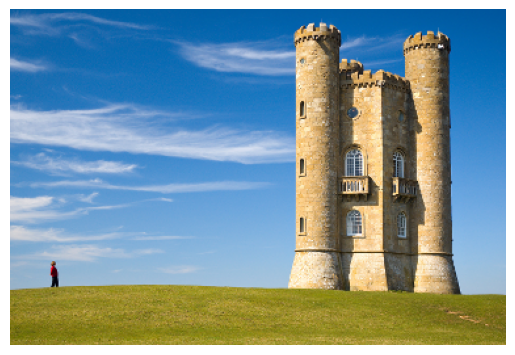

In [7]:
image = cv2.imread("./data/src.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = image/255
plt.imshow(image)
plt.axis("off")

# 1. Image Energy

> **CODE :**
>
> Complete `get_energy`

In [4]:
def get_energy(image: np.ndarray) -> np.ndarray:
    """
    Computes the energy of the gradient of an image

    Args:
        - image (np.ndarray): RGB image with size (h, w, c)

    Returns:
        - energy (np.ndarray): Output energy map, size (h, w)
    """
    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gray /255

    # Compute the gradient of the image
    gradient_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
    gradient_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)

    # Compute the energy of the gradient with L2 norm
    energy = np.sqrt(gradient_x**2 + gradient_y**2)  

    return energy

### Visualizing results

Text(0.5, 1.0, 'Energy of our image')

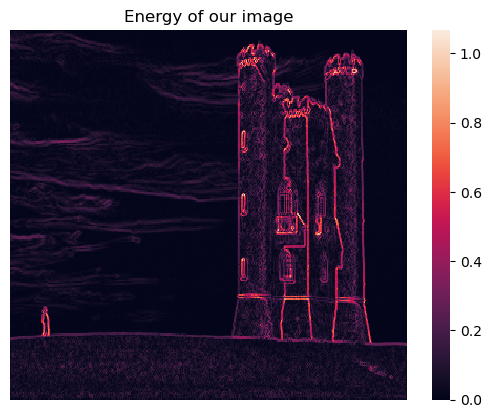

In [8]:
e = get_energy(image)
sns.heatmap(e)
plt.axis("off")
plt.title("Energy of our image")

# 2. Image Costs

> **CODE :**
>
> Complete `path_cost`

In [74]:
def path_cost(energy: np.ndarray) -> np.ndarray:
    """
    Computes the cumulative energy of the map from top to bottom. 
    For each pixel with position (i,j), when we look at the row above, we add the minimal energy of its immediate neighbours, 
    i.e. the minimal energy between (i-1, j-1), (i-1, j) and (i-1, j+1).

    Args:
        - energy (np.ndarray): output of get_energy(), size (h,w)

    Returns:
        - costs (np.ndarray): Cumulative costs of seams, same size as energy
    """
    costs = np.zeros_like(energy)

    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################

    costs = np.zeros_like(energy)

    for i in range( energy.shape[0]):
        for j in range (energy.shape[1]):
            if i == 0:
                costs[i][j] = energy[i][j]
            elif j == 0: 
                costs[i][j] = energy[i][j]+ min(costs[i-1][j],costs[i-1][j+1])
            elif j == energy.shape[1]-1:
                costs[i][j] = energy[i][j]+ min(costs[i-1][j],costs[i-1][j-1])
            else :
                costs[i][j] = energy[i][j]+ min(costs[i-1][j],costs[i-1][j-1],costs[i-1][j+1])
    return costs

### Visualizing results

Text(0.5, 1.0, 'Cumulative costs')

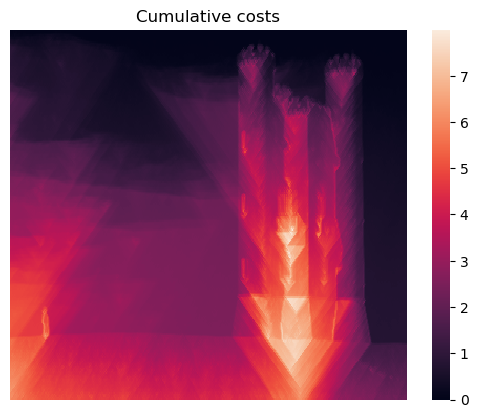

In [75]:
c = path_cost(e)
sns.heatmap(c)
plt.axis("off")
plt.title("Cumulative costs")

> **QUESTION :**
>
> Comment the cumulative costs map. Can you explain why it looks the way it does?
>
> **Réponse :**
>
>Plus on va vers le bas de l'image plus on accumule de l'énergie, donc plus la map affiche des valeurs élevées. Des patterns triangulaires émergent car on regarde seulement les voisins imédiats du haut et en diagonale. Les objets d'importances ressortent dans cette map, car ce sont les objets qui ont le plus de détails (de contours), ainsi leur énergie est plus élevées.

# 3. Minimal Energy seam

> **CODE :**
>
> Complete `get_seam`

In [76]:
def get_seam(costs: np.ndarray) -> np.ndarray:
    """
    Computes the seam of minimal energy in an image

    Args:
        - costs (np.ndarray): Output of path_cost() function, size (h,w)

    Returns:
        - seam (no.ndarray): For each row, contains the index of where the seam goes through, size (h,)
    """
    h, w = costs.shape
    seam = np.ones(h).astype("int64")

    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################
    minIndex =0
    for j in range(costs.shape[1]):        
        if (costs[-1][minIndex] > costs[-1][j]):
            minIndex = j

    seam[-1] = minIndex
        

    for i in range (costs.shape[0]-2,-1,-1):
        previous = seam[i+1]        
        if previous == 0:
            if costs[i][previous] > costs[i][previous+1]:
                seam[i] = previous+1
            else:
                seam[i] = previous
        elif previous == costs.shape[1]-1:
            if costs[i][previous] > costs[i][previous-1]:
                seam[i] = previous-1
            else:
                seam[i] = previous
        else:
            if costs[i][previous] > costs[i][previous-1] and costs[i][previous-1] < costs[i][previous+1]:
                seam[i] = previous-1
            elif costs[i][previous] > costs[i][previous+1] and costs[i][previous+1] < costs[i][previous-1]:
                seam[i] = previous+1
            else:
                seam[i] = previous
    
    return seam

### Visualizing results

Text(0.5, 1.0, 'Minimal Enery seam')

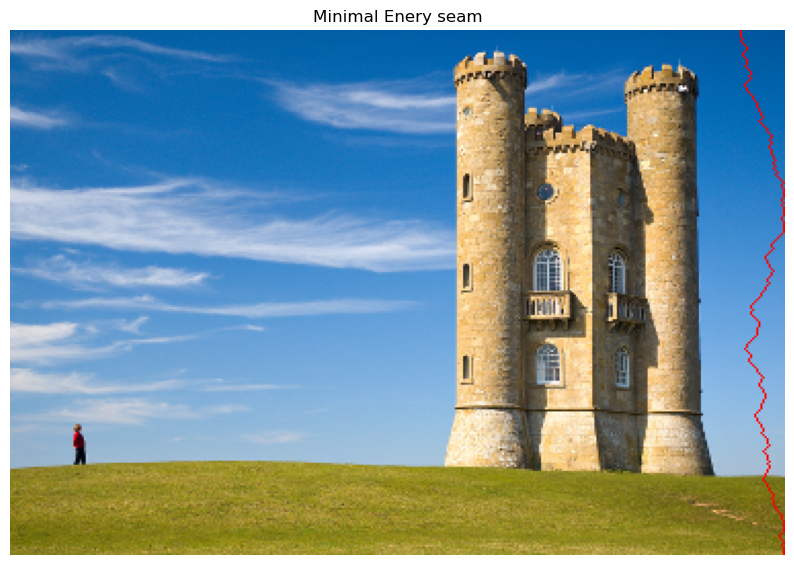

In [77]:
s = get_seam(c)
tmp = image.copy()
h, w, _ = image.shape
for i in range(h):
    tmp[i, s[i]] = (255,0,0)
plt.figure(figsize=(10, 10))
plt.imshow(tmp)
plt.axis("off")
plt.title("Minimal Enery seam")

> **QUESTION :**
>
> Why do we use a seam? Why not :
>- Remove entire columns ?
>- Remove isolated pixels without the 8-connection constraint?
>
> **Réponse :**
>
> Enlever des colonnes entières donnerait des résulats peu cohérents, par exemple le niveau de l'herbe changerait drastiquement d'une colonne de l'image à une autre.
>
> Enlever des pixels isolés sans prendre en compte la 8-connection donnerait également des résulats peu cohérents, on aurrait des décalages de lignes de l'images, par exemple les murs du chateaux perdraient leurs lignes droites.

# 4. Shrinking an image by 25%

> **CODE :**
>
> Complete `shrink_width`

In [78]:
def shrink_width(img: np.ndarray, new_width: int) -> np.ndarray:
    """
    Image must have shape (h, w, c). If image is grayscale, c=1.
    Shrinks a given image to a new width equal to new_width.

    Args:
        - img (np.ndarray): Image we want to shrink
        - new_width (int): New width must verify 1 <  new_width < img.shape[1]

    Return:
        - res (np.ndarray): Shrunk image, size (h, new_width, c)
    """

    h, w, c = img.shape
    nSeams = w - new_width
    print(" We are going to compute {} seams".format(nSeams))
    res = img.copy()

    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################

    if new_width > w or new_width < 1:
        print("New width must verify 1 <  new_width < img.shape[1]")
        return img

    pixelToRemove = image.shape[1] - new_width
    
    for i in range(pixelToRemove):
        energy = get_energy(res)
        costs = path_cost(energy)
        seam = get_seam(costs)
        res = remove_seam(res, seam)
    
    return res

def remove_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    h, w, c = img.shape
    res = np.zeros((h, w-1, c), dtype=np.uint8)

    for i in range(h):
        res[i] = np.delete(img[i], seam[i], axis=0)
    return res

### Visualizing results

 We are going to compute 95 seams


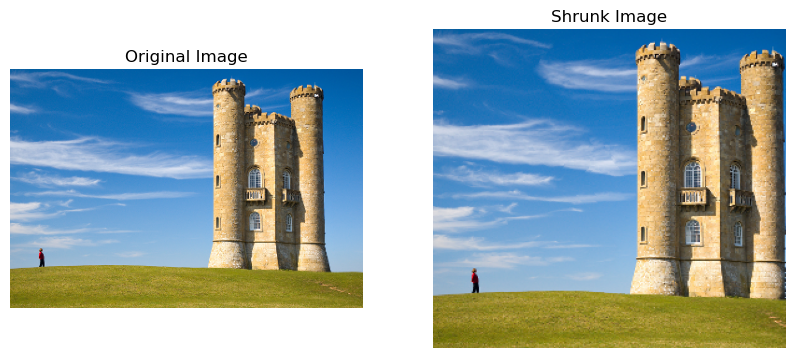

In [79]:
shrinked = shrink_width(image, int(image.shape[1] * 0.75))

f, axs = plt.subplots(1,2, figsize=(10,8))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].title.set_text("Original Image")
axs[1].imshow(shrinked)
axs[1].axis("off")
axs[1].title.set_text("Shrunk Image")

> **QUESTION :**
>
> Analyze the shrunk image. What can you say about the results of the algorithm? Is everything preserved correctly?
>
> **Réponse :**
>
> Les résultats sont assez satisfaisants, les objets d'intérets (la personne et le chateau) sont conservés correctement à l'exception de l'extréminité droite de la tour qui a légèrement était coupé. Les régions de l'image qui ont disparues ne présentaient pas spécialement d'intérets particuliers.

# 5. Enlarging an image by 25%

> **CODE :**
>
> Complete `enlarge_width`

In [111]:
def enlarge_width(img: np.ndarray, new_width: int) -> np.ndarray:
    """
    Image must have shape (h, w, c). If image is grayscale, c=1.
    Enlarges a given image to a new width equal to new_width.
    To prevent the minimal energy seam to always be the same, update the energy map at each iteration
    by multiplying the energy of all the pixels in the used seam by a given coefficient.

    Args:
        - img (np.ndarray): Image we want to shrink
        - new_width (int): New width must verify 1 <  new_width < img.shape[1]

    Return:
        - res (np.ndarray): Enlarged image, size (h, new_width, c)
    """

    h, w, c = img.shape
    coeff = 3
    nSeams = new_width - w
    print(" We are going to compute {} seams".format(nSeams))
    res = img.copy()
    
    ################################################################################################################
    ############################################ Complete the code !################################################
    ################################################################################################################

    if new_width < w or new_width < 1:
        print("New width must verify 1 <  new_width < img.shape[1]")
        return img
    
    pixelToAdd = new_width - image.shape[1]
    energy = get_energy(res)
    costs = path_cost(energy)


    for i in range(pixelToAdd):        
        costs = path_cost(energy)

        seam = get_seam(costs)
        res = add_seam(res, seam)

        for j in range(energy.shape[0]):
            energy[j][seam[j]] = energy[j][seam[j]]*coeff        

        energy = add_seam(energy, seam)   

    
    return res


def add_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    if len(img.shape) == 2:
        h, w = img.shape
        res = np.zeros((h, w+1))
    else:
        h, w, c = img.shape
        res = np.zeros((h, w+1, c), dtype=np.uint8)

    for i in range(h):
        res[i] = np.insert(img[i], seam[i], img[i][seam[i]], axis=0)

    return res


### Visualizing results

 We are going to compute 94 seams


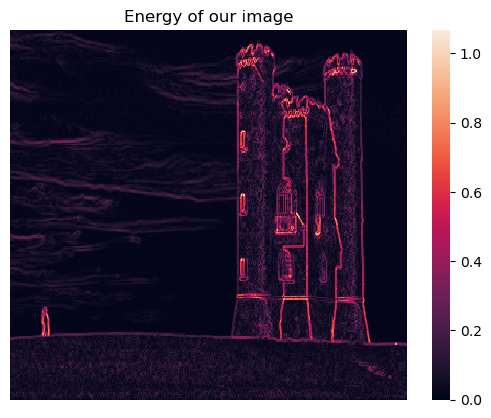

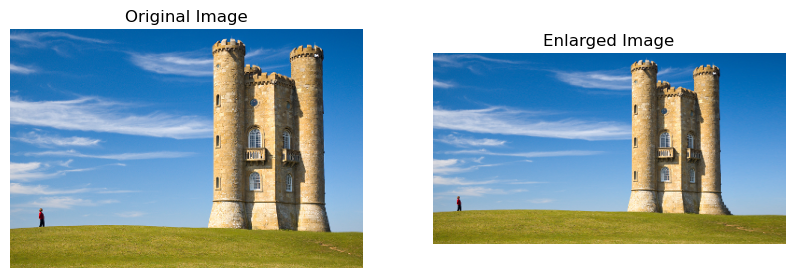

In [108]:
enlarged = enlarge_width(image, int(image.shape[1] * 1.25))
f, axs = plt.subplots(1,2, figsize=(10,8))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].title.set_text("Original Image")
axs[1].imshow(enlarged)
axs[1].axis("off")
axs[1].title.set_text("Enlarged Image")

> **QUESTION :**
>
> Analyze the enlarged image. What can you say about the results of the algorithm? The space at the right should look very empty ; what can you say about its size ? Could it have been possible to add pixels to the left of the image instead of the right, so that the person would not look so far away from the castle ? 
>
> **Réponse :**
>
> Les objets les porportions des objets d'intéret sont parfaitement conservées, les résulats sont donc convaincants. Si plus de pixels avaient été ajoutés à gauche de la personne les nuages auraient eu une apparence très étirée.

> **QUESTION / CODE :**
>
> Among the other images available, find one for which the shrinking is unsatifsying and a different one for wich the enlarging is unsatisfying. Explain why the method fails. You can write the necessary code below.
>
> **Réponse :**
>
> Le shrinking de l'image "oranges.jpg" n'est pas du tout satisfaisant ; en effet, on voit une coupure nette là où le seam a été enlevé. Le seam, par sa nature, est défini à l'endroit où l'énergie de l'image est la plus faible, c'est-à-dire là où il y a le moins de contours. Or, dans cet exemple bien précis, il n'existe pas de chemin ne croisant pas de frontière d'objet. Ainsi, le chemin croisant le moins de frontières se trouve être dans les diagonales passant par le milieu des oranges. On a donc ce résultat avec des oranges qui sont clairement coupées.
>
> Le enlarging de l'image "camera.png" n'est pas convaincant ; en effet, les lignes droites de la table ainsi que du bord de la fenêtre ont été complètement déformées et ne forment plus de lignes droites. Cela est dû au fait que pour agrandir une image, on dédouble le seam de plus faible énergie ; or, dans le cas d'une ligne droite qui n'est pas parallèle au bord de l'image, cette méthode ne permet pas de conserver sa forme. On retrouve ce problème dans l'image "poly.jpg" également.

0it [00:00, ?it/s]

 We are going to compute 135 seams
 We are going to compute 134 seams


1it [01:12, 72.53s/it]

 We are going to compute 240 seams
 We are going to compute 240 seams


2it [07:56, 267.22s/it]

 We are going to compute 151 seams
 We are going to compute 150 seams


3it [09:59, 201.35s/it]

 We are going to compute 225 seams
 We are going to compute 225 seams


4it [16:22, 273.35s/it]

 We are going to compute 128 seams
 We are going to compute 128 seams


5it [17:57, 209.11s/it]

 We are going to compute 82 seams
 We are going to compute 81 seams


6it [18:22, 146.47s/it]

 We are going to compute 125 seams
 We are going to compute 124 seams


7it [19:32, 121.44s/it]

 We are going to compute 95 seams
 We are going to compute 94 seams


8it [20:03, 92.55s/it] 

 We are going to compute 104 seams
 We are going to compute 104 seams


9it [21:21, 142.41s/it]


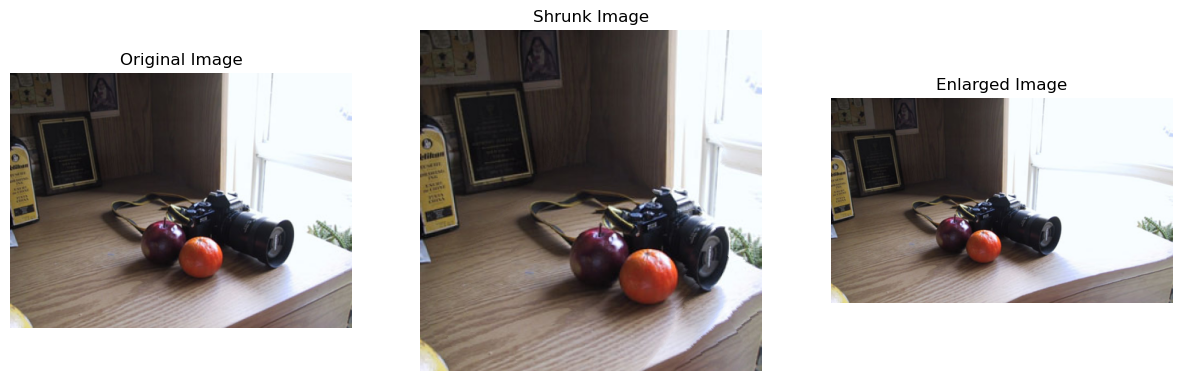

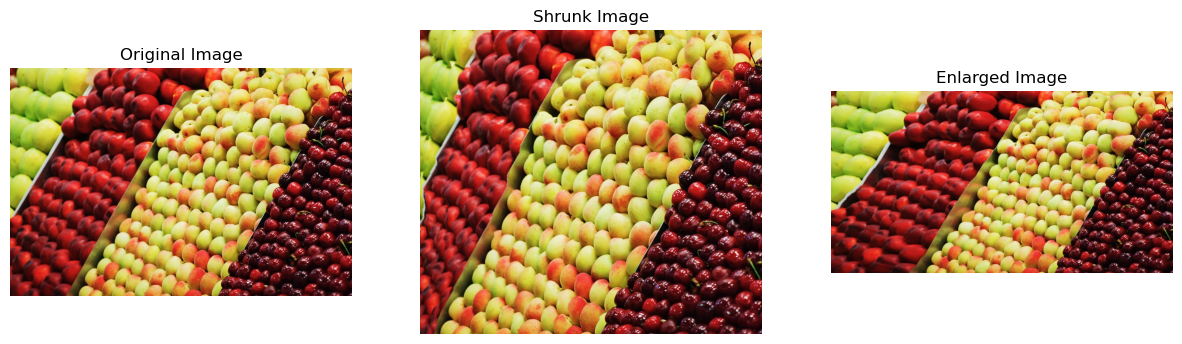

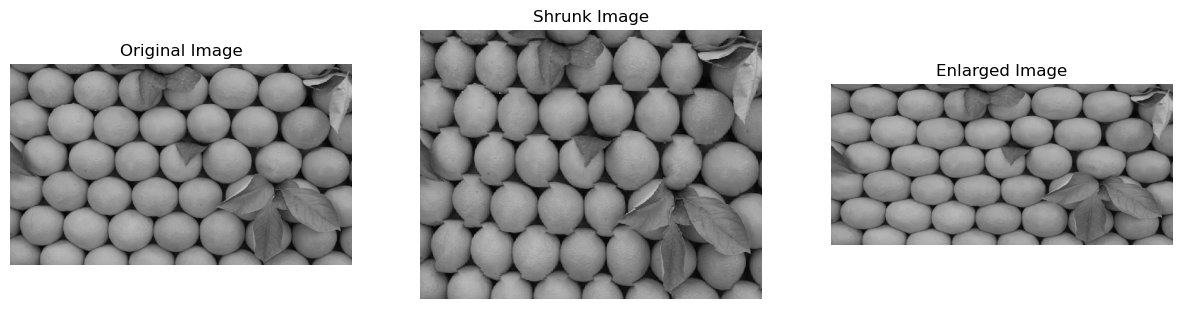

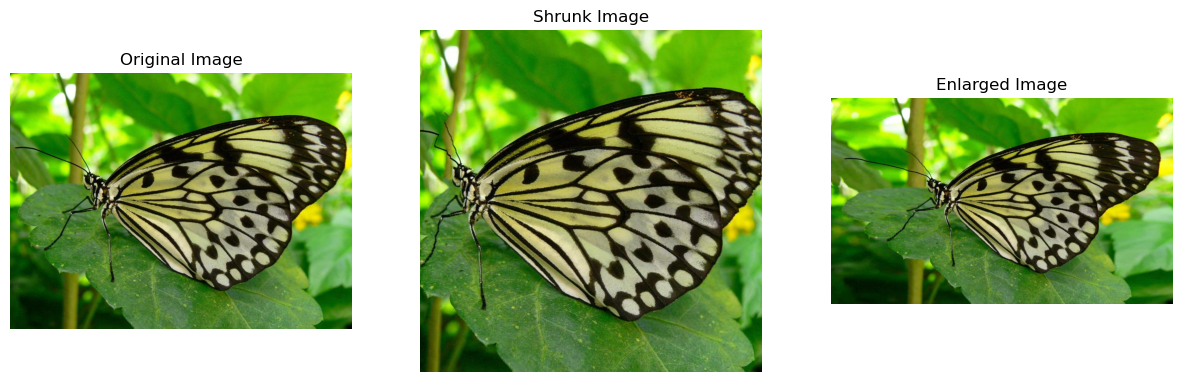

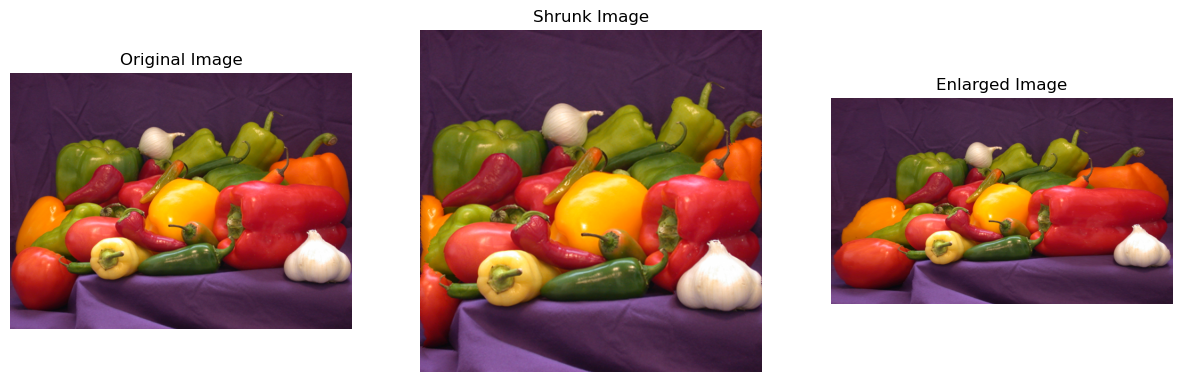

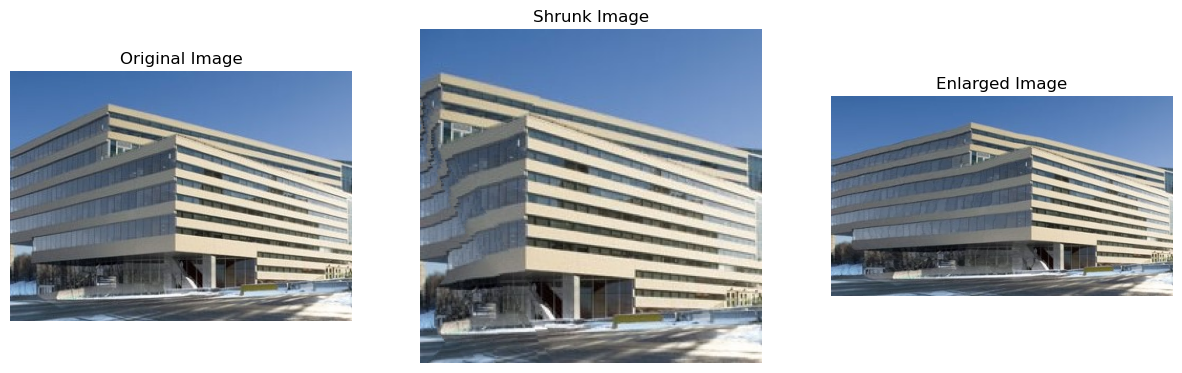

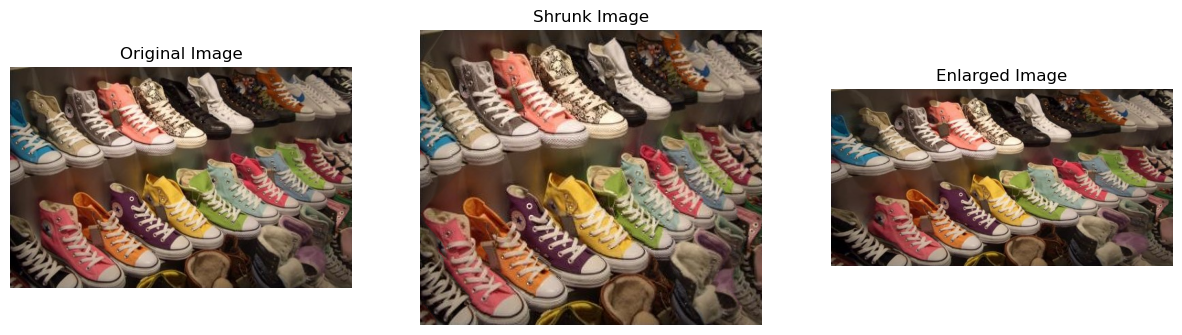

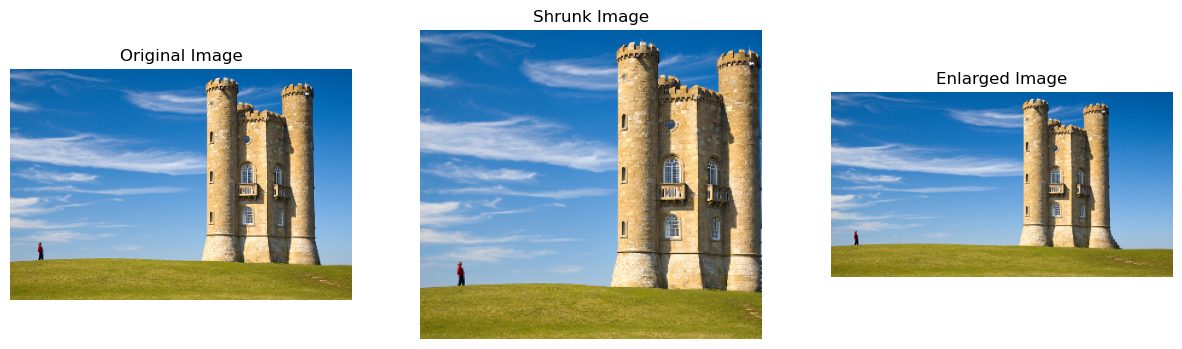

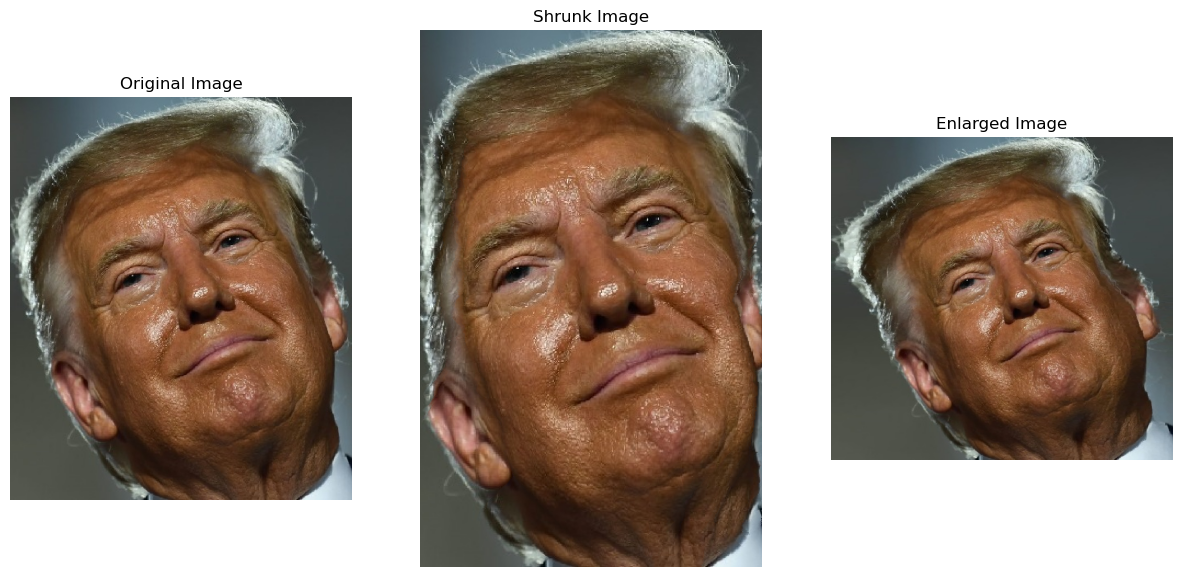

In [112]:
#For each inage in the data folder the shrunk image and the enlarged image 
import os
data_path = "./data"

objects = os.listdir(data_path)
objects_names = [x.split('.')[0] for x in objects]
objects_names.sort()

for obj, name in tqdm(zip(objects, objects_names)):
    image = cv2.imread(os.path.join(data_path, obj))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    shrinked = shrink_width(image, int(image.shape[1] * 0.75))
    enlarged = enlarge_width(image, int(image.shape[1] * 1.25))
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(image)
    axs[0].axis("off")
    axs[0].title.set_text("Original Image")
    axs[1].imshow(shrinked)
    axs[1].axis("off")
    axs[1].title.set_text("Shrunk Image")
    axs[2].imshow(enlarged)
    axs[2].axis("off")
    axs[2].title.set_text("Enlarged Image")
    
    